## 掛接 Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import os
import numpy as np
import tensorflow as tf
import cv2
import tensorflow_datasets as tfds
import tensorflow.keras.layers as layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from tensorflow.keras.applications.vgg16 import VGG16
from tqdm import tqdm,trange

from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D, Concatenate
from keras.applications.inception_v3 import InceptionV3

## 載入資料

In [3]:
# 確認壓縮檔路徑
filepath='/content/drive/MyDrive/CVhw3/'
os.listdir(filepath)

['2022hw3.zip', 'E94074029HW3SC.ipynb']

In [4]:
# # 解壓縮檔案
!unzip '/content/drive/MyDrive/CVhw3/2022hw3.zip' -d '/content/drive/MyDrive/CVhw3/'

串流輸出內容已截斷至最後 5000 行。
  inflating: /content/drive/MyDrive/CVhw3/stanford_dogs/stanfor_dogs/train/n02102973-Irish_water_spaniel/n02102973_1140.jpg  
  inflating: /content/drive/MyDrive/CVhw3/stanford_dogs/stanfor_dogs/train/n02102973-Irish_water_spaniel/n02102973_1200.jpg  
  inflating: /content/drive/MyDrive/CVhw3/stanford_dogs/stanfor_dogs/train/n02102973-Irish_water_spaniel/n02102973_1270.jpg  
  inflating: /content/drive/MyDrive/CVhw3/stanford_dogs/stanfor_dogs/train/n02102973-Irish_water_spaniel/n02102973_1299.jpg  
  inflating: /content/drive/MyDrive/CVhw3/stanford_dogs/stanfor_dogs/train/n02102973-Irish_water_spaniel/n02102973_1318.jpg  
  inflating: /content/drive/MyDrive/CVhw3/stanford_dogs/stanfor_dogs/train/n02102973-Irish_water_spaniel/n02102973_1409.jpg  
  inflating: /content/drive/MyDrive/CVhw3/stanford_dogs/stanfor_dogs/train/n02102973-Irish_water_spaniel/n02102973_158.jpg  
  inflating: /content/drive/MyDrive/CVhw3/stanford_dogs/stanfor_dogs/train/n02102973-Irish_water_s

In [5]:
dirpath='/content/drive/MyDrive/CVhw3/stanford_dogs/stanfor_dogs/'
os.listdir(dirpath) 

['test', 'train']

In [24]:
imgSize=(331,331)
imgShape=(331,331,3)
batchSize=32

# train generator
trainDataGenerator = ImageDataGenerator(rescale = 1/255,
                      # augmentation
                      #rotation_range = 40,
                      #shear_range = 0.3,
                      #zoom_range = 0.2,
                      horizontal_flip = True, 
                      validation_split=0.3)
valDataGenerator = ImageDataGenerator(rescale=1/255,validation_split=0.3)

trainBatch = trainDataGenerator.flow_from_directory(
    directory = dirpath+'train',
    target_size = imgSize,
    class_mode = 'categorical',
    shuffle = True,
    batch_size = batchSize,
    subset='training'
)

valBatch = valDataGenerator.flow_from_directory(
    directory = dirpath+'train',
    target_size = imgSize,
    class_mode = 'categorical',
    shuffle = True,
    batch_size = batchSize,
    subset='validation'
)

# test generator
testDataGenerator = ImageDataGenerator(rescale=1/255)

testBatch = testDataGenerator.flow_from_directory(
    dirpath,
    class_mode=None,
    batch_size=batchSize,
    target_size= imgSize,
    classes=['test'],
    shuffle = False
)


Found 8400 images belonging to 120 classes.
Found 3600 images belonging to 120 classes.
Found 8580 images belonging to 1 classes.


## 載入模型

In [25]:
base_model = tf.keras.applications.NASNetLarge(
    include_top = False,
    weights = 'imagenet',
    input_tensor = None,
    input_shape=imgShape,

)

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)

output_layer = layers.Dense(units = 120, activation = 'softmax')(x)

# # freeze the weight
# base_model.trainable = False

model = tf.keras.Model(inputs = base_model.input, outputs = output_layer)
for layer in base_model.layers:
  layer.trainable=False


In [26]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 331, 331, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv1 (Conv2D)            (None, 165, 165, 96  2592        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn1 (BatchNormalization)  (None, 165, 165, 96  384         ['stem_conv1[0][0]']             
                                )                                                           

In [27]:
# show the model stucture (截圖用)
model1 = tf.keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),
    tf.keras.layers.Dense(120, activation="softmax")
])
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 NASNet (Functional)         (None, 11, 11, 4032)      84916818  
                                                                 
 global_average_pooling2d_5   (None, 4032)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_10 (Dense)            (None, 1024)              4129792   
                                                                 
 dense_11 (Dense)            (None, 120)               123000    
                                                                 
Total params: 89,169,610
Trainable params: 4,252,792
Non-trainable params: 84,916,818
_________________________________________________________________


## train model

In [28]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=8e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [29]:
epoch=3
history = model.fit(
  trainBatch,
  steps_per_epoch = trainBatch.samples // batchSize,
  validation_data = valBatch,
  validation_steps = valBatch.samples // batchSize,
  epochs=epoch,
)

Epoch 1/3
262/262 [==============================] - 870s 3s/step - loss: 1.5590 - accuracy: 0.8353 - val_loss: 0.3165 - val_accuracy: 0.9258
Epoch 2/3
262/262 [==============================] - 840s 3s/step - loss: 0.2436 - accuracy: 0.9364 - val_loss: 0.2555 - val_accuracy: 0.9330
Epoch 3/3
262/262 [==============================] - 834s 3s/step - loss: 0.1913 - accuracy: 0.9443 - val_loss: 0.2502 - val_accuracy: 0.9286


## show the loss & accuracy curve

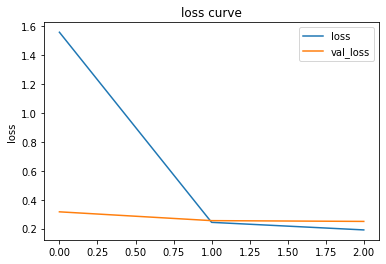

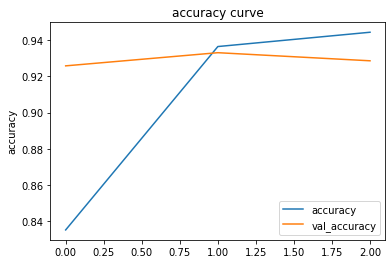

In [30]:
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.title('loss curve')
plt.ylabel('loss')
plt.legend()
plt.show()
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.title('accuracy curve')
plt.ylabel('accuracy')
plt.legend()
plt.show()

## predict test data

In [31]:
prediction = model.predict(testBatch)
prediction

array([[5.52297279e-04, 4.52701328e-03, 8.03309027e-03, ...,
        3.79041594e-04, 4.45592072e-04, 4.34463291e-04],
       [8.99601291e-05, 9.91172850e-01, 6.19936618e-05, ...,
        4.48080573e-05, 1.07285450e-04, 6.20980936e-05],
       [2.85071910e-05, 1.34613638e-05, 3.32972159e-05, ...,
        3.62499995e-05, 7.35544309e-05, 4.36050032e-05],
       ...,
       [8.55821563e-05, 3.86790744e-05, 1.38981661e-04, ...,
        7.37198061e-05, 8.88539798e-05, 1.40620468e-04],
       [9.25085333e-05, 4.94436717e-05, 1.26284358e-04, ...,
        1.06331354e-04, 1.16813222e-04, 2.75034516e-04],
       [2.37417335e-05, 2.57069478e-05, 9.30952083e-05, ...,
        6.29253191e-05, 7.67552629e-05, 1.11532208e-04]], dtype=float32)

## 輸出結果

In [32]:
prediction_label=prediction.argmax(axis=1)
filename=testBatch.filenames
for i in range(len(filename)):
  filename[i]=filename[i][5:]
outputdf=pd.DataFrame()
outputdf['Name']=filename
outputdf['Label']=prediction_label
outputdf.to_csv('/content/drive/MyDrive/CVhw3/E94074029predict.csv',index=False)